In [34]:
from data_utils.utils import *
from merge.heuristics import *

In [35]:
SCITSR_PATH = '/Users/longhoang/Developer/table-recognition/data/scitsr-split-train'
CHUNK_JSON_LABEL = '/Users/longhoang/Developer/table-recognition/data/SciTSR/train/label/chunk_label.json'

scitsr_train = os.path.join(SCITSR_PATH, 'train')
scitsr_val = os.path.join(SCITSR_PATH, 'val')

In [36]:
train_img_dir = os.path.join(scitsr_train, 'img')
imgs_paths = [os.path.join(train_img_dir, p) for p in os.listdir(train_img_dir)]
print(f'Loaded {len(imgs_paths)} images')

chunk_labels = load_json(CHUNK_JSON_LABEL)
print(f'Loaded {len(chunk_labels)} text OCR labels')

merge_label_path = os.path.join(scitsr_train, 'label', 'merge_label.json')
merge_labels = load_json(merge_label_path)
print(f'Loaded {len(merge_labels)} merge labels')

Loaded 10000 images
Loaded 11971 text OCR labels
Loaded 10000 merge labels


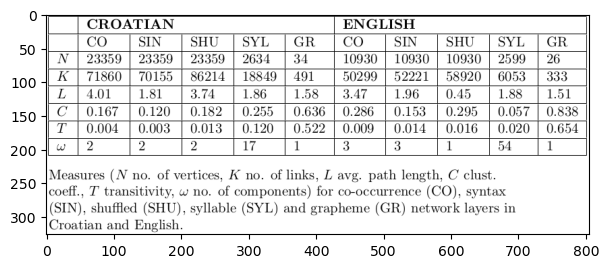

('1507.08539v1.1', dtype('uint8'))

In [37]:
idx = 88
img_path = imgs_paths[idx]
img = load_image(img_path).astype(np.uint8)
img_name = path2name(img_path)
view_imgs([img])
img_name, img.dtype

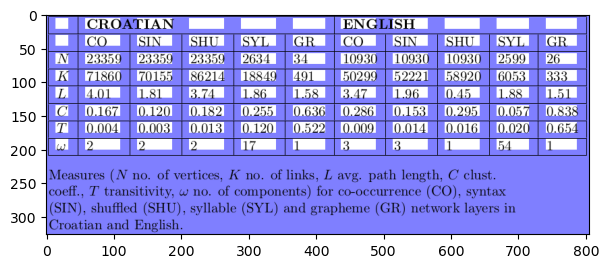

In [38]:
r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
vis_split(img, r_gt, c_gt);

In [39]:
row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
cells_gt = get_cells(row_gt_idxs, col_gt_idxs)

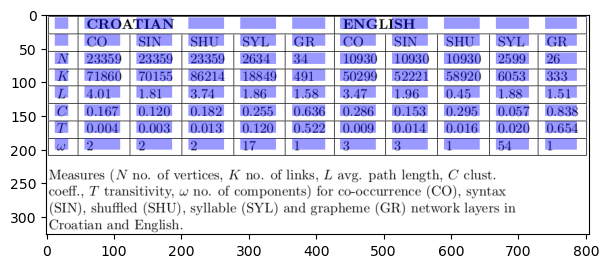

In [40]:
img_boxes = img.copy()
for cell in cells_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 0, 255), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

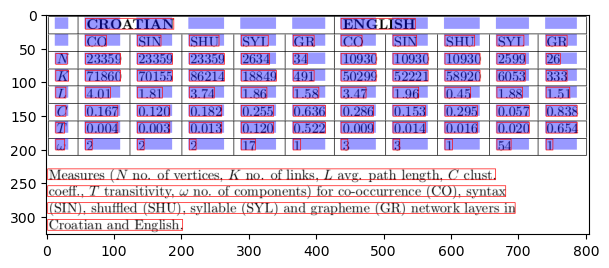

In [41]:
img2 = res.copy()

for text, (l, t, r, b) in chunk_labels[img_name]:
    cv.rectangle(img2, (l, t), (r, b), (255, 0, 0), 1)

view_imgs([img2])

In [42]:
cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt, verbose=True)

Merge right at cell (0,1)
Merge right at cell (0,2)
Merge right at cell (0,3)
Merge right at cell (0,4)
Merge right at cell (0,6)
Merge right at cell (0,7)
Merge right at cell (0,8)
Merge right at cell (0,9)


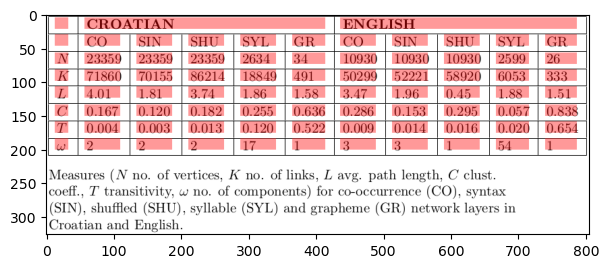

In [43]:
img_boxes = img.copy()
for cell in cells_merged_gt:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (255, 0, 0), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

`Applying Merge heuristics (currently rule 1 & 2)`

In [44]:
texts_pos = chunk_labels[img_name]
R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
rule1(cells_gt, texts_pos, R_pred, D_pred)
rule2(cells_gt, texts_pos, R_pred, D_pred)
cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose=True)

Merge right at cell (0,1)
Merge right at cell (0,2)
Merge right at cell (0,6)
Merge right at cell (0,7)


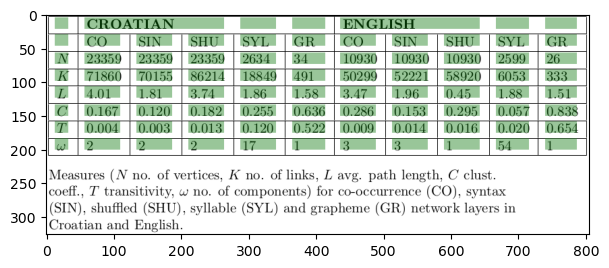

In [45]:
img_boxes = img.copy()
for cell in cells_merged_pred:
    (t, l), (b, r) = cell.pos
    cv.rectangle(img_boxes, (l, t), (r, b), (0, 112, 0), -1)
res = cv.addWeighted(img_boxes, 0.4, img, 0.6, 0)

view_imgs([res])

In [46]:
eval(cells_merged_pred, cells_merged_gt)

(0.9545454545454546, 0.9545454545454546, 0.9545454545454546)

# Putting everything together

In [47]:
def merge_heur_GT(dir, merge_labels, chunk_labels, iou_th=0.7, verbose=False):
    '''
    Args:
    dir -- path to one of train, val, or test dir
    merge_labels -- labels for Merge module
    chunk_labels -- text OCR information
    '''
    single_col_or_row = []
    shape_mismatch = []
    wrong_label = []
    f1s, recalls, precisions = [], [], []
    img_dir = os.path.join(dir, 'img')
    img_paths = [os.path.join(img_dir, p) for p in os.listdir(img_dir)]
    for img_path in img_paths[:5]:
        img = load_image(img_path).astype(np.uint8)
        img_name = path2name(img_path)
        r_gt, c_gt, R_gt, D_gt = load_merge_gt(merge_labels, img_name)
        if R_gt.ndim != 2 or D_gt.ndim != 2: 
            single_col_or_row.append(img_name)
            continue
        row_gt_idxs, col_gt_idxs = borders(r_gt), borders(c_gt)
        if len(row_gt_idxs) == 0 or len(col_gt_idxs) == 0:
            wrong_label.append(img_name)
            continue
        cells_gt = get_cells(row_gt_idxs, col_gt_idxs)
        if len(cells_gt) != R_gt.shape[0] * D_gt.shape[1]:
            shape_mismatch.append(img_name)
            continue
        cells_merged_gt = merge_cells(cells_gt, R_gt, D_gt)
        # semi-prediction
        texts_pos = chunk_labels[img_name]
        R_pred, D_pred = create_pred_matrices(row_gt_idxs, col_gt_idxs)
        rule1(cells_gt, texts_pos, R_pred, D_pred)
        rule2(cells_gt, texts_pos, R_pred, D_pred)
        cells_merged_pred = merge_cells(cells_gt, R_pred, D_pred, verbose)
        # get evaluation scores
        f1, rec, prec = eval(cells_merged_pred, cells_merged_gt, threshold=iou_th)
        f1s.append(f1); recalls.append(rec); precisions.append(prec)
    
    f1_avg, rec_avg, prec_avg = np.mean(f1s), np.mean(recalls), np.mean(precisions)
    print(f'F1: {f1_avg:.4f} ; Recall: {rec_avg:.4f} ; Precision: {prec_avg:.4f}')
    scores = {
        'f1': f1_avg, 'recall': rec_avg, 'precision': prec_avg
    }
    errors = {
        'single': single_col_or_row, 'shape_mismatch': shape_mismatch, 'wrong_label': wrong_label
    }
    return scores, errors

In [52]:
merge_heur_GT(scitsr_train, merge_labels, chunk_labels, iou_th=0.7, verbose=True)

Merge right at cell (0,0)
Merge right at cell (0,2)
Merge right at cell (0,3)
Merge right at cell (0,5)
Merge right at cell (0,1)
F1: 0.9778 ; Recall: 0.9778 ; Precision: 0.9778


({'f1': 0.9777777777777779,
  'recall': 0.9777777777777779,
  'precision': 0.9777777777777779},
 {'single': [], 'shape_mismatch': [], 'wrong_label': []})

In [53]:
val_merge_labels = load_json(os.path.join(scitsr_val, 'label', 'merge_label.json'))
merge_heur_GT(scitsr_val, val_merge_labels, chunk_labels, iou_th=0.7, verbose=True)

F1: 1.0000 ; Recall: 1.0000 ; Precision: 1.0000


({'f1': 1.0, 'recall': 1.0, 'precision': 1.0},
 {'single': [],
  'shape_mismatch': ['1411.0863v1.3', '1504.01777v2.6'],
  'wrong_label': []})